In [1]:
# function to calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size
 
# output layer 1x1 pixel with 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)
# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)
# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


In [2]:
# Cargo todas las librerias a utilizar
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image #Esto permite manipular imagenes

import tensorflow as tf
import tensorflow.keras as kr

import matplotlib.pyplot as plt
import numpy as np

import math
import random

Using TensorFlow backend.


In [3]:
# Definicion del modelo discriminador. Es el que determina si la imagen generada pasará o no el test de realidad
def define_discriminator(image_shape):
	# inicializacion de pesos
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# Capas de la red  
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# Definicion del modelo
	model = Model([in_src_image, in_target_image], patch_out)
	# Compilacion
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [4]:
# Bloque codificador (basicamente son filtro de convolucion)
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [5]:
# Bloque DEcodificador (sin filtros de DEconvolucion)
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [6]:
# Definicion del modelo completo GENERADOR de imagenes
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512 (esta es la parte de codificacion)
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128 (esta es la parte de decodificacion)
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [7]:
# Definicion de la COMBINACION entre el modelo generador y discriminador, para actualizar al generador
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [8]:
# TAMAÑO DE IMAGEN DE ENTRADA
image_shape = (256,256,3)
# DEFINICION DE MODELOS
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# DEFINICION DE MODELO COMBINADO
gan_model = define_gan(g_model, d_model, image_shape)
# SUMARIZACION DEL MODELO
gan_model.summary()
# PLOTEO DE CAPAS (ver imagenes)
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model_2[1][0]                    
Total params: 61,397,

In [9]:
# Esta funcion genera un pequeño dataset de tamaño "n_samples" de imagenes reales
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	#ix = random.randint(0, trainA.shape[0], n_samples)
	ix = random.randint(0, trainA.shape[0]-1)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [10]:
# Esta funcion genera un pequeño dataset de tamaño "samples" de imagenes falsas
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [11]:

# select a batch of real samples
#[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)


# generate a batch of fake samples
#X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

In [12]:

# update discriminator for real samples
#d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
#d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

In [13]:

# update the generator
#g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])



In [11]:
#Esto hace lo mismo que los 3 bloques anteriores
#DEFINICION DE ENTRENAMIENTO
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1, n_patch=16):
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	#n_steps = n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

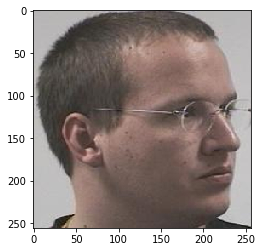

In [12]:
x = image.load_img('D:\github\dataset_train\input\Foto (3).bmp', target_size=(256,256)) #Cargo la imagen y la reshapeo a 299x299 para que sea compatible
#con la red neuronal que tiene ese tamaño de entrada por defecto
x = image.img_to_array(x) #La convierto en matriz

x = (x/255.)

plt.imshow(x)


In [13]:
#CARGO TODAS LAS IMAGENES DEL DATASET 

x = (np.zeros(182*1*256*256*3)).reshape(182,1,256,256,3)
y = (np.zeros(182*1*256*256*3)).reshape(182,1,256,256,3)

i = 0
for i in range(182):
    i = i + 1
    path = r"D:\github\dataset_train\input\Foto (" + str(i) + ").bmp"
    aux = image.load_img(path, target_size=(256,256))
    x[i-1] =  image.img_to_array(aux)
    path = r"D:\github\dataset_train\output\Foto (" + str(i) + ").bmp"
    aux = image.load_img(path, target_size=(256,256))
    y[i-1] =  image.img_to_array(aux)    

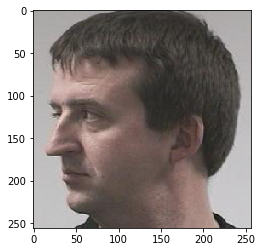

In [14]:
#para verificacion

pepe = x[181][0]/255.
#pepe = image.load_img('.\DSC02185.png', target_size=(256,256))
#pepe = image.img_to_array(pepe)
#pepe = pepe/255.
plt.imshow(pepe)

In [15]:
from keras.models import load_model
g_model.load_weights('first_try.h5')
d_model = load_model('modelo_discriminador')
gan_model = load_model('modelo_gan')

Instructions for updating:
Use tf.cast instead.


OSError: Unable to open file (truncated file: eof = 502334800, sblock->base_addr = 0, stored_eof = 519112016)

In [18]:
# load image data
dataset = x,y
# train model
train(d_model, g_model, gan_model, dataset)
g_model.save('modelo_generador')
g_model.save_weights('first_try.h5')
d_model.save('modelo_discriminador')
gan_model.save('modelo_gan')

>1, d1[0.000] d2[0.000] g[11943.283]
>2, d1[0.000] d2[0.000] g[11552.865]
>3, d1[0.000] d2[0.000] g[9862.915]
>4, d1[0.000] d2[0.000] g[10779.212]
>5, d1[0.000] d2[0.000] g[7955.844]
>6, d1[0.000] d2[0.000] g[11477.532]
>7, d1[0.000] d2[0.000] g[11426.187]
>8, d1[0.000] d2[0.000] g[8338.282]
>9, d1[0.000] d2[0.000] g[10503.060]
>10, d1[0.000] d2[0.000] g[10257.916]
>11, d1[0.000] d2[0.000] g[10148.479]
>12, d1[0.000] d2[0.000] g[8562.586]
>13, d1[0.000] d2[0.000] g[11425.921]
>14, d1[0.000] d2[0.000] g[9731.894]
>15, d1[0.000] d2[0.000] g[11146.432]
>16, d1[0.000] d2[0.000] g[9839.247]
>17, d1[0.000] d2[0.000] g[9971.750]
>18, d1[0.000] d2[0.000] g[11074.461]
>19, d1[0.000] d2[0.000] g[10629.653]
>20, d1[0.000] d2[0.000] g[11734.290]
>21, d1[0.000] d2[0.000] g[11835.947]
>22, d1[0.000] d2[0.000] g[10387.786]
>23, d1[0.000] d2[0.000] g[9262.472]
>24, d1[0.000] d2[0.000] g[12915.736]
>25, d1[0.000] d2[0.000] g[9253.612]
>26, d1[0.000] d2[0.000] g[10387.731]
>27, d1[0.000] d2[0.000] g[106

>216, d1[0.000] d2[0.000] g[11660.585]
>217, d1[0.000] d2[0.000] g[11616.455]
>218, d1[0.000] d2[0.000] g[9580.781]
>219, d1[0.000] d2[0.000] g[8831.101]
>220, d1[0.000] d2[0.000] g[9336.100]
>221, d1[0.000] d2[0.000] g[13413.729]
>222, d1[0.000] d2[0.000] g[9656.621]
>223, d1[0.000] d2[0.000] g[11146.585]
>224, d1[0.000] d2[0.000] g[9404.763]
>225, d1[0.000] d2[0.000] g[9977.573]
>226, d1[0.000] d2[0.000] g[10558.682]
>227, d1[0.000] d2[0.000] g[11506.269]
>228, d1[0.000] d2[0.000] g[10126.337]
>229, d1[0.000] d2[0.000] g[10145.188]
>230, d1[0.000] d2[0.000] g[9977.433]
>231, d1[0.000] d2[0.000] g[10716.030]
>232, d1[0.000] d2[0.000] g[12533.407]
>233, d1[0.000] d2[0.000] g[9318.655]
>234, d1[0.000] d2[0.000] g[12622.766]
>235, d1[0.000] d2[0.000] g[11279.375]
>236, d1[0.000] d2[0.000] g[9784.430]
>237, d1[0.000] d2[0.000] g[10890.084]
>238, d1[0.000] d2[0.000] g[10622.526]
>239, d1[0.000] d2[0.000] g[9426.280]
>240, d1[0.000] d2[0.000] g[10616.297]
>241, d1[0.000] d2[0.000] g[11628.8

>429, d1[0.000] d2[0.000] g[11426.598]
>430, d1[0.000] d2[0.000] g[10321.573]
>431, d1[0.000] d2[0.000] g[9914.152]
>432, d1[0.000] d2[0.000] g[9732.295]
>433, d1[0.000] d2[0.000] g[9857.460]
>434, d1[0.000] d2[0.000] g[9731.771]
>435, d1[0.000] d2[0.000] g[11031.822]
>436, d1[0.000] d2[0.000] g[12725.637]
>437, d1[0.000] d2[0.000] g[9253.318]
>438, d1[0.000] d2[0.000] g[11043.663]
>439, d1[0.000] d2[0.000] g[11930.115]
>440, d1[0.000] d2[0.000] g[12260.707]
>441, d1[0.000] d2[0.000] g[12882.645]
>442, d1[0.000] d2[0.000] g[7954.222]
>443, d1[0.000] d2[0.000] g[12240.885]
>444, d1[0.000] d2[0.000] g[10622.428]
>445, d1[0.000] d2[0.000] g[11071.178]
>446, d1[0.000] d2[0.000] g[10892.595]
>447, d1[0.000] d2[0.000] g[9764.608]
>448, d1[0.000] d2[0.000] g[10075.041]
>449, d1[0.000] d2[0.000] g[10796.229]
>450, d1[0.000] d2[0.000] g[11071.126]
>451, d1[0.000] d2[0.000] g[10395.155]
>452, d1[0.000] d2[0.000] g[10279.645]
>453, d1[0.000] d2[0.000] g[12957.770]
>454, d1[0.000] d2[0.000] g[1045

>641, d1[0.000] d2[0.000] g[12533.065]
>642, d1[0.000] d2[0.000] g[7953.959]
>643, d1[0.000] d2[0.000] g[11323.331]
>644, d1[0.000] d2[0.000] g[11509.584]
>645, d1[0.000] d2[0.000] g[9416.799]
>646, d1[0.000] d2[0.000] g[10796.333]
>647, d1[0.000] d2[0.000] g[12725.273]
>648, d1[0.000] d2[0.000] g[10148.004]
>649, d1[0.000] d2[0.000] g[12260.326]
>650, d1[0.000] d2[0.000] g[10392.496]
>651, d1[0.000] d2[0.000] g[11073.978]
>652, d1[0.000] d2[0.000] g[9679.012]
>653, d1[0.000] d2[0.000] g[10144.894]
>654, d1[0.000] d2[0.000] g[10395.012]
>655, d1[0.000] d2[0.000] g[10125.960]
>656, d1[0.000] d2[0.000] g[10279.421]
>657, d1[0.000] d2[0.000] g[10551.942]
>658, d1[0.000] d2[0.000] g[11205.348]
>659, d1[0.000] d2[0.000] g[11145.987]
>660, d1[0.000] d2[0.000] g[10551.834]
>661, d1[0.000] d2[0.000] g[11499.750]
>662, d1[0.000] d2[0.000] g[9977.443]
>663, d1[0.000] d2[0.000] g[12784.915]
>664, d1[0.000] d2[0.000] g[9655.604]
>665, d1[0.000] d2[0.000] g[8212.103]
>666, d1[0.000] d2[0.000] g[973

>853, d1[0.000] d2[0.000] g[10528.357]
>854, d1[0.000] d2[0.000] g[12260.312]
>855, d1[0.000] d2[0.000] g[11646.037]
>856, d1[0.000] d2[0.000] g[9298.540]
>857, d1[0.000] d2[0.000] g[10429.058]
>858, d1[0.000] d2[0.000] g[9425.782]
>859, d1[0.000] d2[0.000] g[11505.716]
>860, d1[0.000] d2[0.000] g[9154.852]
>861, d1[0.000] d2[0.000] g[10928.680]
>862, d1[0.000] d2[0.000] g[12425.621]
>863, d1[0.000] d2[0.000] g[12634.682]
>864, d1[0.000] d2[0.000] g[9855.588]
>865, d1[0.000] d2[0.000] g[9564.933]
>866, d1[0.000] d2[0.000] g[11640.425]
>867, d1[0.000] d2[0.000] g[7953.853]
>868, d1[0.000] d2[0.000] g[11270.271]
>869, d1[0.000] d2[0.000] g[10279.355]
>870, d1[0.000] d2[0.000] g[12873.985]
>871, d1[0.000] d2[0.000] g[9404.068]
>872, d1[0.000] d2[0.000] g[11505.769]
>873, d1[0.000] d2[0.000] g[10270.327]
>874, d1[0.000] d2[0.000] g[9731.343]
>875, d1[0.000] d2[0.000] g[11393.790]
>876, d1[0.000] d2[0.000] g[11929.805]
>877, d1[0.000] d2[0.000] g[10920.668]
>878, d1[0.000] d2[0.000] g[7953.

>1064, d1[0.000] d2[0.000] g[9327.414]
>1065, d1[0.000] d2[0.000] g[10818.546]
>1066, d1[0.000] d2[0.000] g[11031.294]
>1067, d1[0.000] d2[0.000] g[11584.102]
>1068, d1[0.000] d2[0.000] g[9838.742]
>1069, d1[0.000] d2[0.000] g[11270.220]
>1070, d1[0.000] d2[0.000] g[8809.484]
>1071, d1[0.000] d2[0.000] g[9876.833]
>1072, d1[0.000] d2[0.000] g[9876.756]
>1073, d1[0.000] d2[0.000] g[11499.603]
>1074, d1[0.000] d2[0.000] g[11270.210]
>1075, d1[0.000] d2[0.000] g[13208.600]
>1076, d1[0.000] d2[0.000] g[11962.299]
>1077, d1[0.000] d2[0.000] g[13095.619]
>1078, d1[0.000] d2[0.000] g[9252.856]
>1079, d1[0.000] d2[0.000] g[9764.317]
>1080, d1[0.000] d2[0.000] g[10920.749]
>1081, d1[0.000] d2[0.000] g[8734.314]
>1082, d1[0.000] d2[0.000] g[11074.056]
>1083, d1[0.000] d2[0.000] g[12957.596]
>1084, d1[0.000] d2[0.000] g[9327.430]
>1085, d1[0.000] d2[0.000] g[9273.470]
>1086, d1[0.000] d2[0.000] g[9855.580]
>1087, d1[0.000] d2[0.000] g[10270.404]
>1088, d1[0.000] d2[0.000] g[11659.741]
>1089, d1[0

>1271, d1[0.000] d2[0.000] g[11500.228]
>1272, d1[0.000] d2[0.000] g[9839.113]
>1273, d1[0.000] d2[0.000] g[12529.223]
>1274, d1[0.000] d2[0.000] g[9874.437]
>1275, d1[0.000] d2[0.000] g[12957.898]
>1276, d1[0.000] d2[0.000] g[10502.835]
>1277, d1[0.000] d2[0.000] g[10601.231]
>1278, d1[0.000] d2[0.000] g[11325.863]
>1279, d1[0.000] d2[0.000] g[7954.125]
>1280, d1[0.000] d2[0.000] g[12882.533]
>1281, d1[0.000] d2[0.000] g[10920.758]
>1282, d1[0.000] d2[0.000] g[11930.060]
>1283, d1[0.000] d2[0.000] g[8341.068]
>1284, d1[0.000] d2[0.000] g[11191.369]
>1285, d1[0.000] d2[0.000] g[11279.370]
>1286, d1[0.000] d2[0.000] g[10260.852]
>1287, d1[0.000] d2[0.000] g[11499.837]
>1288, d1[0.000] d2[0.000] g[10291.093]
>1289, d1[0.000] d2[0.000] g[11540.776]
>1290, d1[0.000] d2[0.000] g[11394.175]
>1291, d1[0.000] d2[0.000] g[9343.451]
>1292, d1[0.000] d2[0.000] g[12635.356]
>1293, d1[0.000] d2[0.000] g[12785.101]
>1294, d1[0.000] d2[0.000] g[8804.592]
>1295, d1[0.000] d2[0.000] g[11250.083]
>1296,

>1478, d1[0.000] d2[0.000] g[13208.637]
>1479, d1[0.000] d2[0.000] g[11509.502]
>1480, d1[0.000] d2[0.000] g[10796.231]
>1481, d1[0.000] d2[0.000] g[9327.453]
>1482, d1[0.000] d2[0.000] g[9661.592]
>1483, d1[0.000] d2[0.000] g[12358.387]
>1484, d1[0.000] d2[0.000] g[13034.108]
>1485, d1[0.000] d2[0.000] g[10918.312]
>1486, d1[0.000] d2[0.000] g[13379.315]
>1487, d1[0.000] d2[0.000] g[10345.548]
>1488, d1[0.000] d2[0.000] g[9977.321]
>1489, d1[0.000] d2[0.000] g[9911.815]
>1490, d1[0.000] d2[0.000] g[9431.936]
>1491, d1[0.000] d2[0.000] g[10191.846]
>1492, d1[0.000] d2[0.000] g[10918.338]
>1493, d1[0.000] d2[0.000] g[10502.481]
>1494, d1[0.000] d2[0.000] g[10594.558]
>1495, d1[0.000] d2[0.000] g[10440.725]
>1496, d1[0.000] d2[0.000] g[13412.793]
>1497, d1[0.000] d2[0.000] g[9876.319]
>1498, d1[0.000] d2[0.000] g[11043.259]
>1499, d1[0.000] d2[0.000] g[9731.314]
>1500, d1[0.000] d2[0.000] g[11270.195]
>1501, d1[0.000] d2[0.000] g[11628.193]
>1502, d1[0.000] d2[0.000] g[10836.345]
>1503, 

>1685, d1[0.000] d2[0.000] g[10889.604]
>1686, d1[0.000] d2[0.000] g[11476.740]
>1687, d1[0.000] d2[0.000] g[10450.615]
>1688, d1[0.000] d2[0.000] g[10615.783]
>1689, d1[0.000] d2[0.000] g[11054.115]
>1690, d1[0.000] d2[0.000] g[12957.535]
>1691, d1[0.000] d2[0.000] g[10551.638]
>1692, d1[0.000] d2[0.000] g[9579.334]
>1693, d1[0.000] d2[0.000] g[10528.189]
>1694, d1[0.000] d2[0.000] g[10928.630]
>1695, d1[0.000] d2[0.000] g[11179.463]
>1696, d1[0.000] d2[0.000] g[10318.218]
>1697, d1[0.000] d2[0.000] g[12532.918]
>1698, d1[0.000] d2[0.000] g[12211.771]
>1699, d1[0.000] d2[0.000] g[12790.322]
>1700, d1[0.000] d2[0.000] g[8340.798]
>1701, d1[0.000] d2[0.000] g[11929.592]
>1702, d1[0.000] d2[0.000] g[9678.762]
>1703, d1[0.000] d2[0.000] g[10600.958]
>1704, d1[0.000] d2[0.000] g[9005.605]
>1705, d1[0.000] d2[0.000] g[11054.075]
>1706, d1[0.000] d2[0.000] g[11113.745]
>1707, d1[0.000] d2[0.000] g[10525.604]
>1708, d1[0.000] d2[0.000] g[9252.937]
>1709, d1[0.000] d2[0.000] g[12716.623]
>1710

>1892, d1[0.000] d2[0.000] g[10502.414]
>1893, d1[0.000] d2[0.000] g[11628.122]
>1894, d1[0.000] d2[0.000] g[10270.311]
>1895, d1[0.000] d2[0.000] g[12211.692]
>1896, d1[0.000] d2[0.000] g[9252.726]
>1897, d1[0.000] d2[0.000] g[11962.049]
>1898, d1[0.000] d2[0.000] g[9913.648]
>1899, d1[0.000] d2[0.000] g[11270.150]
>1900, d1[0.000] d2[0.000] g[12462.323]
>1901, d1[0.000] d2[0.000] g[10345.383]
>1902, d1[0.000] d2[0.000] g[9499.147]
>1903, d1[0.000] d2[0.000] g[10929.911]
>1904, d1[0.000] d2[0.000] g[10594.445]
>1905, d1[0.000] d2[0.000] g[11823.247]
>1906, d1[0.000] d2[0.000] g[12462.310]
>1907, d1[0.000] d2[0.000] g[9678.712]
>1908, d1[0.000] d2[0.000] g[13095.438]
>1909, d1[0.000] d2[0.000] g[10836.252]
>1910, d1[0.000] d2[0.000] g[12915.023]
>1911, d1[0.000] d2[0.000] g[11145.758]
>1912, d1[0.000] d2[0.000] g[11393.576]
>1913, d1[0.000] d2[0.000] g[10125.751]
>1914, d1[0.000] d2[0.000] g[9327.328]
>1915, d1[0.000] d2[0.000] g[9977.159]
>1916, d1[0.000] d2[0.000] g[8809.387]
>1917, 

>2099, d1[0.000] d2[0.000] g[9655.391]
>2100, d1[0.000] d2[0.000] g[10318.204]
>2101, d1[0.000] d2[0.000] g[11645.881]
>2102, d1[0.000] d2[0.000] g[11205.235]
>2103, d1[0.000] d2[0.000] g[8829.666]
>2104, d1[0.000] d2[0.000] g[10818.449]
>2105, d1[0.000] d2[0.000] g[10502.417]
>2106, d1[0.000] d2[0.000] g[11070.815]
>2107, d1[0.000] d2[0.000] g[10715.679]
>2108, d1[0.000] d2[0.000] g[11179.425]
>2109, d1[0.000] d2[0.000] g[13412.573]
>2110, d1[0.000] d2[0.000] g[12622.195]
>2111, d1[0.000] d2[0.000] g[11476.533]
>2112, d1[0.000] d2[0.000] g[10635.637]
>2113, d1[0.000] d2[0.000] g[12358.212]
>2114, d1[0.000] d2[0.000] g[11325.394]
>2115, d1[0.000] d2[0.000] g[9318.009]
>2116, d1[0.000] d2[0.000] g[11145.750]
>2117, d1[0.000] d2[0.000] g[8340.729]
>2118, d1[0.000] d2[0.000] g[11290.175]
>2119, d1[0.000] d2[0.000] g[12358.203]
>2120, d1[0.000] d2[0.000] g[9856.419]
>2121, d1[0.000] d2[0.000] g[9499.074]
>2122, d1[0.000] d2[0.000] g[10257.357]
>2123, d1[0.000] d2[0.000] g[10615.745]
>2124,

>2306, d1[0.000] d2[0.000] g[10129.219]
>2307, d1[0.000] d2[0.000] g[13379.190]
>2308, d1[0.000] d2[0.000] g[11499.488]
>2309, d1[0.000] d2[0.000] g[11205.162]
>2310, d1[0.000] d2[0.000] g[10440.519]
>2311, d1[0.000] d2[0.000] g[9431.756]
>2312, d1[0.000] d2[0.000] g[10095.635]
>2313, d1[0.000] d2[0.000] g[10129.236]
>2314, d1[0.000] d2[0.000] g[10622.044]
>2315, d1[0.000] d2[0.000] g[10594.397]
>2316, d1[0.000] d2[0.000] g[10918.214]
>2317, d1[0.000] d2[0.000] g[10615.708]
>2318, d1[0.000] d2[0.000] g[12687.609]
>2319, d1[0.000] d2[0.000] g[9005.517]
>2320, d1[0.000] d2[0.000] g[10920.312]
>2321, d1[0.000] d2[0.000] g[10394.791]
>2322, d1[0.000] d2[0.000] g[10600.909]
>2323, d1[0.000] d2[0.000] g[13412.628]
>2324, d1[0.000] d2[0.000] g[11790.780]
>2325, d1[0.000] d2[0.000] g[10074.371]
>2326, d1[0.000] d2[0.000] g[10129.188]
>2327, d1[0.000] d2[0.000] g[8809.338]
>2328, d1[0.000] d2[0.000] g[9403.766]
>2329, d1[0.000] d2[0.000] g[8829.673]
>2330, d1[0.000] d2[0.000] g[10345.367]
>2331

>2513, d1[0.000] d2[0.000] g[11073.741]
>2514, d1[0.000] d2[0.000] g[10829.721]
>2515, d1[0.000] d2[0.000] g[11615.223]
>2516, d1[0.000] d2[0.000] g[8829.647]
>2517, d1[0.000] d2[0.000] g[10600.855]
>2518, d1[0.000] d2[0.000] g[11322.863]
>2519, d1[0.000] d2[0.000] g[9637.921]
>2520, d1[0.000] d2[0.000] g[8733.965]
>2521, d1[0.000] d2[0.000] g[10622.026]
>2522, d1[0.000] d2[0.000] g[11322.929]
>2523, d1[0.000] d2[0.000] g[10551.568]
>2524, d1[0.000] d2[0.000] g[10191.628]
>2525, d1[0.000] d2[0.000] g[13379.150]
>2526, d1[0.000] d2[0.000] g[10892.059]
>2527, d1[0.000] d2[0.000] g[12528.720]
>2528, d1[0.000] d2[0.000] g[12211.671]
>2529, d1[0.000] d2[0.000] g[9252.701]
>2530, d1[0.000] d2[0.000] g[10774.675]
>2531, d1[0.000] d2[0.000] g[8829.641]
>2532, d1[0.000] d2[0.000] g[10529.045]
>2533, d1[0.000] d2[0.000] g[12260.106]
>2534, d1[0.000] d2[0.000] g[10428.806]
>2535, d1[0.000] d2[0.000] g[9327.283]
>2536, d1[0.000] d2[0.000] g[10836.200]
>2537, d1[0.000] d2[0.000] g[9838.621]
>2538, 

>2720, d1[0.000] d2[0.000] g[9838.609]
>2721, d1[0.000] d2[0.000] g[12914.981]
>2722, d1[0.000] d2[0.000] g[13033.941]
>2723, d1[0.000] d2[0.000] g[10327.965]
>2724, d1[0.000] d2[0.000] g[11509.305]
>2725, d1[0.000] d2[0.000] g[9783.589]
>2726, d1[0.000] d2[0.000] g[9678.642]
>2727, d1[0.000] d2[0.000] g[10594.373]
>2728, d1[0.000] d2[0.000] g[10796.028]
>2729, d1[0.000] d2[0.000] g[9661.365]
>2730, d1[0.000] d2[0.000] g[11179.393]
>2731, d1[0.000] d2[0.000] g[9317.978]
>2732, d1[0.000] d2[0.000] g[9678.646]
>2733, d1[0.000] d2[0.000] g[11053.969]
>2734, d1[0.000] d2[0.000] g[9911.626]
>2735, d1[0.000] d2[0.000] g[11073.749]
>2736, d1[0.000] d2[0.000] g[10774.676]
>2737, d1[0.000] d2[0.000] g[9154.707]
>2738, d1[0.000] d2[0.000] g[9856.380]
>2739, d1[0.000] d2[0.000] g[10502.406]
>2740, d1[0.000] d2[0.000] g[9154.736]
>2741, d1[0.000] d2[0.000] g[11073.715]
>2742, d1[0.000] d2[0.000] g[13412.498]
>2743, d1[0.000] d2[0.000] g[9971.016]
>2744, d1[0.000] d2[0.000] g[10929.712]
>2745, d1[0

>2927, d1[0.000] d2[0.000] g[10129.185]
>2928, d1[0.000] d2[0.000] g[9273.253]
>2929, d1[0.000] d2[0.000] g[11325.319]
>2930, d1[0.000] d2[0.000] g[12022.781]
>2931, d1[0.000] d2[0.000] g[10207.128]
>2932, d1[0.000] d2[0.000] g[9563.593]
>2933, d1[0.000] d2[0.000] g[10144.652]
>2934, d1[0.000] d2[0.000] g[10528.120]
>2935, d1[0.000] d2[0.000] g[13324.884]
>2936, d1[0.000] d2[0.000] g[10594.369]
>2937, d1[0.000] d2[0.000] g[11476.531]
>2938, d1[0.000] d2[0.000] g[12784.604]
>2939, d1[0.000] d2[0.000] g[11583.871]
>2940, d1[0.000] d2[0.000] g[11205.108]
>2941, d1[0.000] d2[0.000] g[11628.071]
>2942, d1[0.000] d2[0.000] g[11659.564]
>2943, d1[0.000] d2[0.000] g[10889.542]
>2944, d1[0.000] d2[0.000] g[10635.595]
>2945, d1[0.000] d2[0.000] g[11476.489]
>2946, d1[0.000] d2[0.000] g[9403.781]
>2947, d1[0.000] d2[0.000] g[11929.536]
>2948, d1[0.000] d2[0.000] g[10279.139]
>2949, d1[0.000] d2[0.000] g[10095.522]
>2950, d1[0.000] d2[0.000] g[8855.580]
>2951, d1[0.000] d2[0.000] g[12790.220]
>295

>3134, d1[0.000] d2[0.000] g[10191.579]
>3135, d1[0.000] d2[0.000] g[11109.280]
>3136, d1[0.000] d2[0.000] g[7953.625]
>3137, d1[0.000] d2[0.000] g[10829.604]
>3138, d1[0.000] d2[0.000] g[9876.648]
>3139, d1[0.000] d2[0.000] g[10818.403]
>3140, d1[0.000] d2[0.000] g[10260.403]
>3141, d1[0.000] d2[0.000] g[11835.158]
>3142, d1[0.000] d2[0.000] g[8340.707]
>3143, d1[0.000] d2[0.000] g[9184.649]
>3144, d1[0.000] d2[0.000] g[9298.338]
>3145, d1[0.000] d2[0.000] g[10928.488]
>3146, d1[0.000] d2[0.000] g[9677.545]
>3147, d1[0.000] d2[0.000] g[10290.767]
>3148, d1[0.000] d2[0.000] g[11249.472]
>3149, d1[0.000] d2[0.000] g[10622.005]
>3150, d1[0.000] d2[0.000] g[13095.426]
>3151, d1[0.000] d2[0.000] g[10628.859]
>3152, d1[0.000] d2[0.000] g[7953.630]
>3153, d1[0.000] d2[0.000] g[11476.606]
>3154, d1[0.000] d2[0.000] g[9856.367]
>3155, d1[0.000] d2[0.000] g[9327.217]
>3156, d1[0.000] d2[0.000] g[10615.674]
>3157, d1[0.000] d2[0.000] g[9154.690]
>3158, d1[0.000] d2[0.000] g[11583.809]
>3159, d1[

>3341, d1[0.000] d2[0.000] g[10392.033]
>3342, d1[0.000] d2[0.000] g[10428.779]
>3343, d1[0.000] d2[0.000] g[12957.313]
>3344, d1[0.000] d2[0.000] g[11929.491]
>3345, d1[0.000] d2[0.000] g[11031.141]
>3346, d1[0.000] d2[0.000] g[10889.511]
>3347, d1[0.000] d2[0.000] g[10551.479]
>3348, d1[0.000] d2[0.000] g[11505.528]
>3349, d1[0.000] d2[0.000] g[10074.377]
>3350, d1[0.000] d2[0.000] g[9057.442]
>3351, d1[0.000] d2[0.000] g[11179.399]
>3352, d1[0.000] d2[0.000] g[8887.857]
>3353, d1[0.000] d2[0.000] g[10144.551]
>3354, d1[0.000] d2[0.000] g[11073.717]
>3355, d1[0.000] d2[0.000] g[10600.843]
>3356, d1[0.000] d2[0.000] g[13208.450]
>3357, d1[0.000] d2[0.000] g[9464.702]
>3358, d1[0.000] d2[0.000] g[11628.019]
>3359, d1[0.000] d2[0.000] g[10270.253]
>3360, d1[0.000] d2[0.000] g[11393.511]
>3361, d1[0.000] d2[0.000] g[10600.864]
>3362, d1[0.000] d2[0.000] g[10460.263]
>3363, d1[0.000] d2[0.000] g[10715.541]
>3364, d1[0.000] d2[0.000] g[10621.968]
>3365, d1[0.000] d2[0.000] g[9425.516]
>336

>3548, d1[0.000] d2[0.000] g[11379.560]
>3549, d1[0.000] d2[0.000] g[12240.393]
>3550, d1[0.000] d2[0.000] g[11540.003]
>3551, d1[0.000] d2[0.000] g[9425.551]
>3552, d1[0.000] d2[0.000] g[12240.426]
>3553, d1[0.000] d2[0.000] g[10892.054]
>3554, d1[0.000] d2[0.000] g[9425.523]
>3555, d1[0.000] d2[0.000] g[10129.184]
>3556, d1[0.000] d2[0.000] g[9855.334]
>3557, d1[0.000] d2[0.000] g[10290.670]
>3558, d1[0.000] d2[0.000] g[11053.928]
>3559, d1[0.000] d2[0.000] g[11640.157]
>3560, d1[0.000] d2[0.000] g[11109.238]
>3561, d1[0.000] d2[0.000] g[10074.321]
>3562, d1[0.000] d2[0.000] g[10125.625]
>3563, d1[0.000] d2[0.000] g[13033.902]
>3564, d1[0.000] d2[0.000] g[12622.139]
>3565, d1[0.000] d2[0.000] g[8337.312]
>3566, d1[0.000] d2[0.000] g[10635.600]
>3567, d1[0.000] d2[0.000] g[11290.083]
>3568, d1[0.000] d2[0.000] g[9273.227]
>3569, d1[0.000] d2[0.000] g[9252.656]
>3570, d1[0.000] d2[0.000] g[10551.510]
>3571, d1[0.000] d2[0.000] g[9911.584]
>3572, d1[0.000] d2[0.000] g[12784.508]
>3573, 

RuntimeError: Unable to flush file's cached information (unable to extend file properly)

In [23]:
g_model.save('modelo_generador')
g_model.save_weights('first_try.h5')
d_model.save('modelo_discriminador')
gan_model.save('modelo_gan2')

In [16]:
pepe2 = g_model.predict(pepe.reshape(1,256,256,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


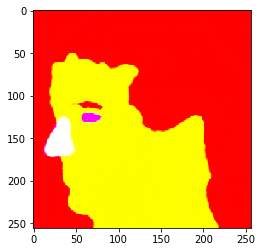

In [17]:
plt.imshow(pepe2.reshape(256,256,3))